In [1]:
import importlib
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu

In [2]:
# Import package 
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [4]:
# User Input parameters
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/gold_standards')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg')

ALIGNMENT_MAG = 2
TILE_MAG = 10
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1910_T_9637_2_TP53.svs',
 '1910_T_9637_3_HandE.svs',
 '1919_T_10779_2_TP53.svs',
 '1919_T_10779_3_HandE.svs']

In [5]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1910_T_9637_2_TP53.svs', '1910_T_9637_3_HandE.svs'),
 ('1919_T_10779_2_TP53.svs', '1919_T_10779_3_HandE.svs')]

In [51]:
SLIDE_NUM = 1
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 1919_T_10779_2_


In [52]:
def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [53]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

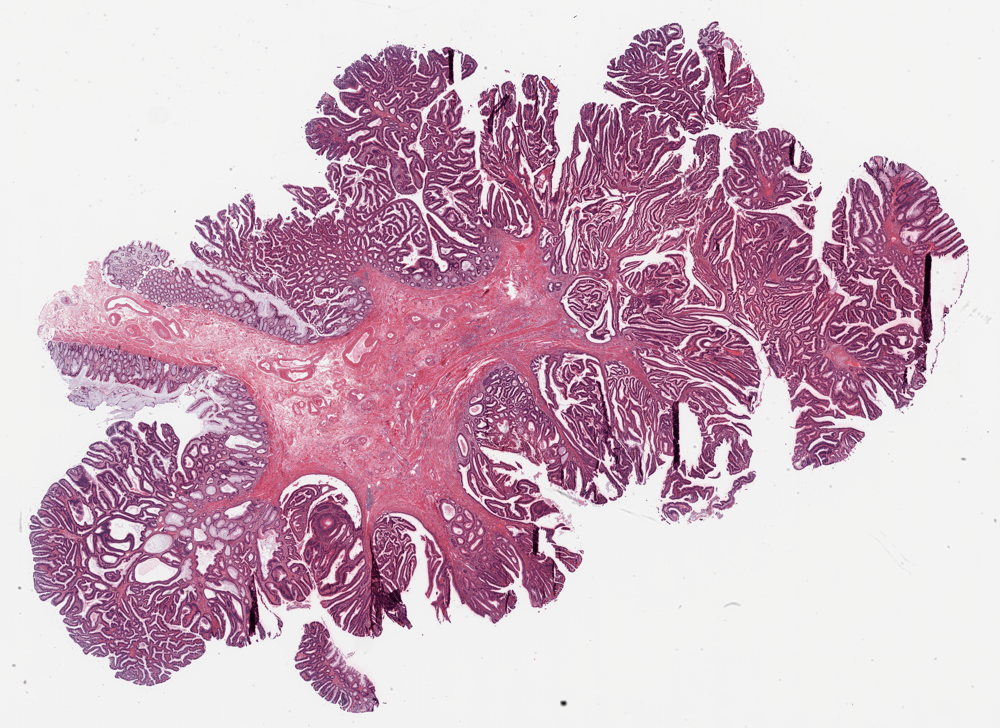

In [54]:
thumbnail(he)

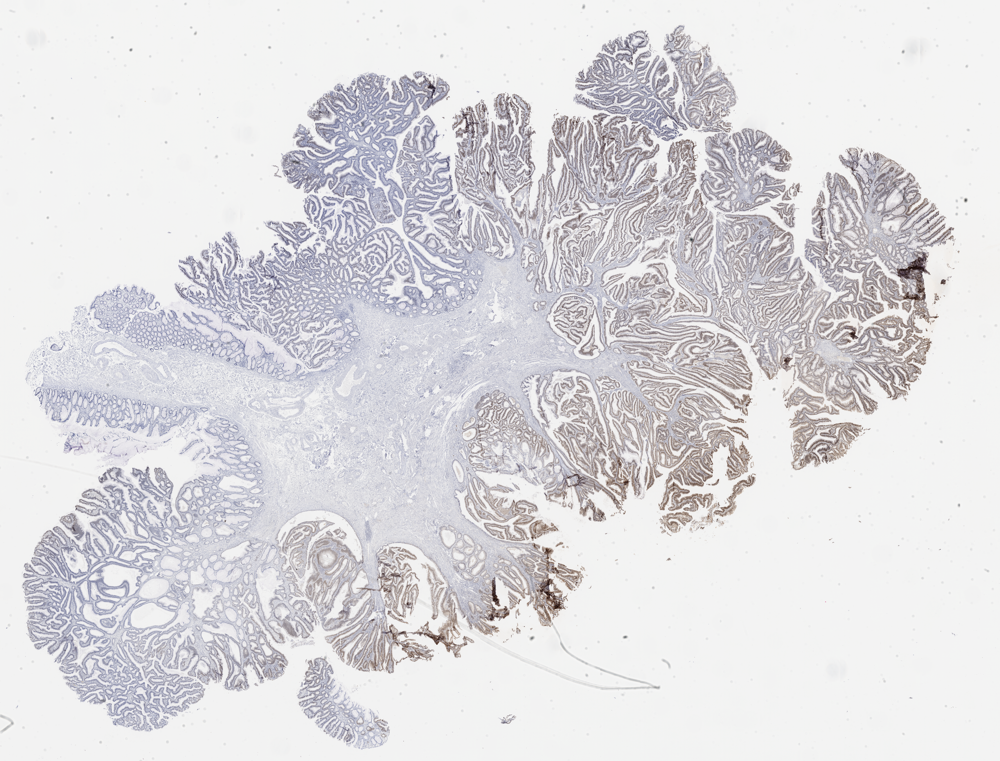

In [55]:
thumbnail(tp53)

In [56]:
######################
# Image Registration #
######################

INTERPOLATOR = sitk.sitkLanczosWindowedSinc

#Convert to grayscale
tp53_gray = tp53.convert('L')
he_gray = he.convert('L')
#Convert to ITK format
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)
#Set fixed and moving images
fixed_img = he_itk
moving_img = tp53_itk


In [57]:

# Check initial registration
# Centre the two images, then compare their alignment
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
moving_rgb = sitk_transform_rgb(tp53, he, initial_transform)
comparison_pre = show_alignment(he, moving_rgb, prefilter = True)
verbose_save_img(comparison_pre.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'comparison_pre_registration.jpeg'), 'JPEG' )

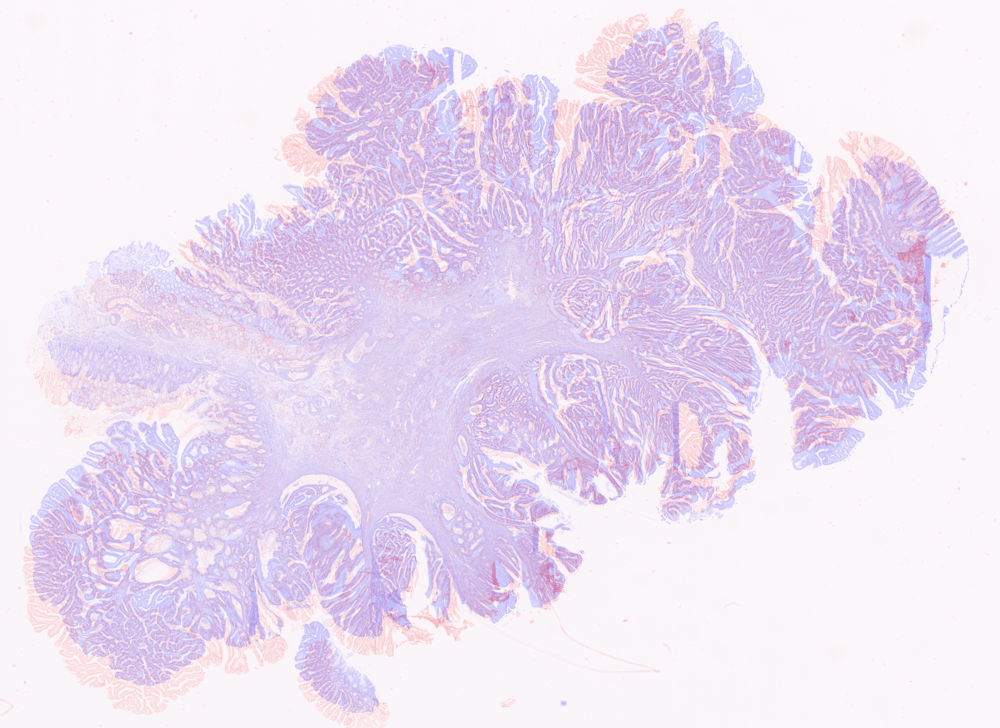

In [58]:
thumbnail(comparison_pre)

In [59]:
################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays 
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')
    
def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [60]:
np.argmax([2,3,4])

2

In [61]:
def optimal_angle(tp53, he):
    #Convert to grayscale
    tp53_gray = tp53.convert('L')
    he_gray = he.convert('L')
    #Find optimal angle
    angles = [0, 90, 180, 270]
    mutual_infos = []
    for angle in angles:
        tp53_rotated = tp53_gray.rotate(angle)
        tp53_rotated_itk = get_itk_from_pil(tp53_rotated)
        he_gray_itk = get_itk_from_pil(he_gray)
        initial_transform = sitk.CenteredTransformInitializer(tp53_rotated_itk, he_gray_itk, sitk.Euler2DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
        tp53_resampled = sitk.Resample(tp53_rotated_itk, he_gray_itk, initial_transform, 
                                     sitk.sitkLanczosWindowedSinc, 0.0, moving_img.GetPixelID())
        he_gray_array = np.array(get_pil_from_itk(he_gray_itk))
        tp53_resampled_array = np.array(get_pil_from_itk(tp53_resampled))
        mi = calculate_mutual_info(he_gray_array, tp53_resampled_array)
        mutual_infos.append(mi)  
    return angles[np.argmax(mutual_infos)]
    

In [62]:
angle = optimal_angle(tp53, he)

In [63]:
#Convert to grayscale
tp53 = tp53.rotate(angle)
tp53_gray = tp53.convert('L')
he_gray = he.convert('L')
#Convert to ITK format
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)
#Set fixed and moving images
fixed_img = he_itk
moving_img = tp53_itk

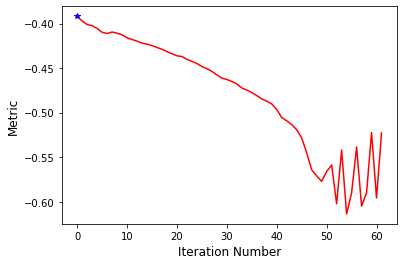

In [ ]:
#Affine Registration
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
affine_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
affine_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
affine_method.SetMetricSamplingStrategy(affine_method.RANDOM)
affine_method.SetMetricSamplingPercentage(0.15)

affine_method.SetInterpolator(INTERPOLATOR)

# Optimizer settings.
affine_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
affine_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
affine_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4])
affine_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2])
affine_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
affine_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
affine_method.AddCommand(sitk.sitkStartEvent, start_plot)
affine_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
affine_method.AddCommand(sitk.sitkIterationEvent, lambda: update_plot(affine_method))

affine_transform = affine_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

affine_fig = plot_metric('Plot of mutual information cost in affine registration')
plt.show()
verbose_save_fig(affine_fig, OUTPUT_PATH.joinpath(PREFIX + 'affine_metric_plot.jpeg'))
end_plot()

verbose_print('Affine metric value: {0}'.format(affine_method.GetMetricValue()))
verbose_print('Affine Optimizer\'s stopping condition, {0}'.format(affine_method.GetOptimizerStopConditionDescription()))

In [ ]:
#Compute the mutual information between the two images after affine registration
moving_resampled_affine = sitk.Resample(moving_img, fixed_img, affine_transform, 
                                 INTERPOLATOR, 0.0, moving_img.GetPixelID())
affine_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled_affine)))
verbose_print('Affine mutual information metric: {0}'.format(affine_mutual_info))

In [ ]:
#B-spline registration
bspline_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
bspline_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
bspline_method.SetMetricSamplingStrategy(bspline_method.RANDOM)
bspline_method.SetMetricSamplingPercentage(0.15)

bspline_method.SetInterpolator(INTERPOLATOR)

# Optimizer settings.
bspline_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
bspline_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
bspline_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
bspline_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,0])
bspline_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_resampled_affine.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
bspline_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
bspline_method.AddCommand(sitk.sitkStartEvent, start_plot)
bspline_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
bspline_method.AddCommand(sitk.sitkIterationEvent, lambda: update_plot(bspline_method))

bspline_transform = bspline_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_resampled_affine, sitk.sitkFloat32))

bspline_fig = plot_metric('Plot of mutual information cost in B-spline registration')
plt.show()
verbose_save_fig(bspline_fig, OUTPUT_PATH.joinpath(PREFIX + 'bspline_metric_plot.jpeg'))
end_plot()

verbose_print('B-spline metric value: {0}'.format(bspline_method.GetMetricValue()))
verbose_print('B-spline Optimizer\'s stopping condition, {0}'.format(bspline_method.GetOptimizerStopConditionDescription()))

In [ ]:
#Compute the mutual information between the two images after B-spline registration
moving_resampled_final = sitk.Resample(moving_resampled_affine, fixed_img, bspline_transform, 
                                 INTERPOLATOR, 0.0, moving_img.GetPixelID())
bspline_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled_final)))
verbose_print('B-spline mutual information metric: {0}'.format(bspline_mutual_info))

In [ ]:
#Transform the original TP53 into the aligned TP53 image
moving_rgb_affine = sitk_transform_rgb(tp53, he, affine_transform, INTERPOLATOR)
tp53_aligned = sitk_transform_rgb(moving_rgb_affine, he, bspline_transform, INTERPOLATOR)
thumbnail(show_alignment(he, tp53_aligned, prefilter = True))

In [ ]:
#Remove backgrounds from TP53 and H&E images
tp53_filtered = filter_green(tp53_aligned)
he_filtered = filter_green(he)
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he_filtered, tolerance = 15)

#Visually compare alignment between the registered TP53 and original H&E image
comparison_post = show_alignment(he_filtered, tp53_filtered)

In [ ]:
thumbnail(comparison_post)